In [2]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import sys
sys.path.append("/home/mylab-pharma/Code/tuele/XO/src/common")
from pharmacy_common import PharmacyCommon

#class to encode smiles
common = PharmacyCommon()

Import the dataset

In [3]:
train_dataset = pd.read_excel('../../data/train_test_data/XO_train_test_data.xlsx',sheet_name='train_dataset')
validation_dataset = pd.read_excel('../../data/train_test_data/XO_train_test_data.xlsx', sheet_name='validation_dataset')
test_dataset = pd.read_excel('../../data/train_test_data/XO_train_test_data.xlsx', sheet_name='test_dataset')
print(len(train_dataset),len(validation_dataset), len(test_dataset))

337 73 73


In [4]:
train_dataset.head(10)

,CID,SMILES,IC50(nM),Type,substructure
0,145967694,CC1=CC2=C(C=C1)N=C(O2)/C(=N/O)/CC3=CC=CC=C3,17500.0,active,7
1,76329670,CC1(C=CC2=CC(=C(C=C2O1)O)C(=O)/C=C/C3=CC(=C(C=...,1800.0,inactive,16
2,5320686,C1=CC(=CC=C1/C=C/C(=O)OC[C@@H]2[C@H]([C@@H]([C...,100000.0,active,6
3,155903284,C1=CC(=CC=C1C2=NC=NN2)NC(=O)C3C(NC(=O)NC3=O)O,1400.0,inactive,1
4,137648214,CCCCC1=NN2C(=N1)C3=C(NC2=O)NN=C3,529.0,inactive,9
5,156780202,C1=CC=C(C=C1)CN2C=C(C3=C2C=CC(=C3)NC(=O)C4=CC(...,820.0,inactive,3
6,135463610,CCCCSC1=NC(=C(C(=O)N1)NC=O)N,100000.0,active,3
7,156705027,C1=CC(=CC=C1COC2=C(C=C(C=C2)C3=NC=C4C(=N3)NNC4...,151.0,inactive,3
8,162680022,C1=CN=C(C=C1NC(=O)C2C(NC(=O)NC2=O)O)C(=O)NO,73800.0,active,7
9,24896701,CCC[C@H](C[C@@H]1[C@@H](C2=CC(=C(C(=C2C(=O)O1)...,612000.0,active,2


In [5]:
#encoding smiles 
fpt_bits = 1024
X_train = common.gen_ecfp4_fpts(train_dataset['SMILES'],bits= fpt_bits)
X_validation = common.gen_ecfp4_fpts(validation_dataset['SMILES'],bits= fpt_bits)
X_test = common.gen_ecfp4_fpts(test_dataset['SMILES'], bits= fpt_bits)

Progress:   0%|          | 0/337 [00:00<?, ?it/s][20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:55] DEPRECATION WARNING: please use MorganGenerator
[20:00:

In [6]:
print(X_train.shape, X_validation.shape, X_test.shape)

(337, 1024) (73, 1024) (73, 1024)


In [8]:
# encoding the label
import sklearn.preprocessing as preprocessing
y_train = np.array(train_dataset['Type'])
y_validation = np.array(validation_dataset['Type'])
y_test = np.array(test_dataset['Type'])

#Original data
print("Original data:")
print(y_train[0:5])
print(y_test[0:5])
print(y_validation[0:5])

#label encoding
label_encoder = preprocessing.LabelEncoder()
y_train  = label_encoder.fit_transform(y_train)
y_validation = label_encoder.fit_transform(y_validation)
y_test = label_encoder.fit_transform(y_test)
#Class encoded
print("Class encoded:")
print(list(label_encoder.classes_))
print(label_encoder.transform(label_encoder.classes_))
print("Encoded data:")
print(y_train[0:5])
print(y_test[0:5])
print(y_validation[0:5])

Original data:
['active' 'inactive' 'active' 'inactive' 'inactive']
['inactive' 'inactive' 'active' 'active' 'inactive']
['active' 'inactive' 'active' 'active' 'active']
Class encoded:
['active', 'inactive']
[0 1]
Encoded data:
[0 1 0 1 1]
[1 1 0 0 1]
[0 1 0 0 0]


In [9]:
#converting to tensor 
X_train_df = pd.DataFrame(X_train)
X_validation_df = pd.DataFrame(X_validation)
X_test_df = pd.DataFrame(X_test)

X_train = torch.tensor(X_train_df.values, dtype=torch.float32)
X_validation = torch.tensor(X_validation_df.values, dtype=torch.float32)
X_test = torch.tensor(X_test_df.values, dtype=torch.float32)

y_train_df = pd.DataFrame(y_train)
y_validation_df = pd.DataFrame(y_validation)
y_test_df = pd.DataFrame(y_test)

y_train = torch.tensor(y_train_df.values, dtype=torch.float32)
y_validation = torch.tensor(y_validation_df.values, dtype=torch.float32)
y_test = torch.tensor(y_test_df.values, dtype=torch.float32)

In [10]:
# Create train and test datasets
train_dataset = TensorDataset(X_train, y_train)
validation_dataset= TensorDataset(X_validation, y_validation)
test_dataset = TensorDataset(X_test, y_test)
print(len(train_dataset), len(validation_dataset), len(test_dataset))

337 73 73


In [11]:
# Define the data loaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Construct and sanity-check the model

In [12]:
data_train = X_train
data_valdation = X_validation
data_test = X_test

labels_validation = y_validation
labels_test = y_test
labels_train= y_train.float()
print(len(data_train), len(labels_train),len(data_valdation),
    len(labels_validation), len(data_test), len(labels_test))
print(data_train)
print(labels_train)

337 337 73 73 73 73
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]

Model

In [13]:
# model
class ann_try(nn.Module):
    def __init__(self, input_dim=len(X_train[0]),layer1=512,layer2=256,drp=.9,output=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,layer1),
            nn.ReLU(),
            nn.Dropout(drp),
            nn.Linear(layer1,layer2),
            nn.ReLU(),
            nn.Dropout(drp),
            nn.Linear(layer2,output),
            nn.Sigmoid(),
        )
    def forward(self,input):
        return self.net(input)

In [18]:
from sklearn.model_selection import cross_val_score
# trainning
def training(x_train = X_train,y_train=y_train,x_validation = X_validation,
            #  y_validation = y_validation,lr=0.001,l2=0.001,batch_size=64,epochs=100):
            y_validation = y_validation,lr=0.007206041689487159,l2=0.004176049826978714,batch_size=128,epochs=300):
    torch.manual_seed(0)
    losses=[]
    train_ds = TensorDataset(x_train, y_train)
    # train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
    train_dl = DataLoader(train_ds, batch_size=batch_size)
    model = ann_try()
    loss_func = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=l2)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # pred = model(X_train)
        # loss = loss_func(pred, y_train)
        # loss.backward()
        # optimizer.step()
        # optimizer.zero_grad()
        if epoch==0 or  epoch % 2 == 0:
            print(loss)
        losses.append(loss)
    losses_tensor = torch.tensor(losses)
    plt.title("Loss in training")
    plt.xlabel('Numepoch')
    plt.ylabel('Loss_value')
    plt.plot(losses_tensor.detach())
    
    model.eval()
    #for train
    y_pred_train = model(x_train)
    loss_train = loss_func(y_pred_train,y_train)
    y_pred_train_bin = y_pred_train>.5
    acc_train = 100*torch.mean((y_pred_train_bin == y_train).float())
    # for validation
    y_pred_val = model(x_validation)
    loss_val = loss_func(y_pred_val, y_validation)
    y_pred_val_bin = y_pred_val>.5
    acc_val = 100*torch.mean((y_pred_val_bin == y_validation).float())
    
    # mse = mean_squared_error(model(x_validation).detach().numpy(),y_.detach().numpy())
    print('Accuracy on train set:' ,acc_train)
    print('Accuracy on validation set:' ,acc_val)
    print('Loss on train set:' ,loss_train)
    print('Loss on validation set:' ,loss_val)
    return acc_train, acc_val,model #to specify what to maximize in this function

tensor(0.7078, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6597, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4812, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4196, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3706, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2655, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3518, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4963, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5103, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3170, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4927, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2742, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2478, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2691, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3055, grad_fn=<Bina

(tensor(93.4718),
 tensor(91.7808),
 ann_try(
   (net): Sequential(
     (0): Linear(in_features=1024, out_features=512, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.9, inplace=False)
     (3): Linear(in_features=512, out_features=256, bias=True)
     (4): ReLU()
     (5): Dropout(p=0.9, inplace=False)
     (6): Linear(in_features=256, out_features=1, bias=True)
     (7): Sigmoid()
   )
 ))

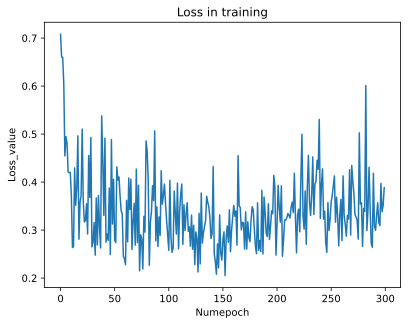

In [19]:
acc_train, acc_val, model = training(X_train,y_train,X_validation,y_validation)


In [65]:
y_pred_test = model(X_test)>.5
acc_test = 100*torch.mean((y_pred_test == y_test).float())
print(acc_test)

tensor(87.6712)


In [15]:
X_train_val = torch.cat((X_train, X_validation), dim=0)
y_train_val = torch.cat((y_train, y_validation), dim=0)
print(X_train_val.shape, y_train_val.shape)

torch.Size([410, 1024]) torch.Size([410, 1])


In [19]:
from sklearn.model_selection import cross_val_score, KFold

def training_with_K_folds(x_train=X_train, y_train=y_train, x_validation=X_validation, y_validation=y_validation,
             lr=0.007206041689487159, l2=0.004176049826978714, batch_size=128, epochs=300, num_folds=5):
    torch.manual_seed(0)
    losses = []
    model = ann_try()
    loss_func = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    
    kf = KFold(n_splits=num_folds, shuffle=True)
    fold_train_accuracies = []
    fold_val_accuracies = []

    for fold, (train_index, val_index) in enumerate(kf.split(x_train)):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        train_ds = TensorDataset(x_train_fold, y_train_fold)
        train_dl = DataLoader(train_ds, batch_size=batch_size)

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_dl:
                pred = model(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # if epoch == 0 or epoch % 2 == 0:
            #     print(f"Fold {fold+1} - Epoch {epoch+1} Loss: {loss.item()}")

            losses.append(loss)

        model.eval()
        y_pred_train = model(x_train_fold) > 0.5
        acc_train = 100 * torch.mean((y_pred_train == y_train_fold).float())
        y_pred_val = model(x_val_fold) > 0.5
        acc_val = 100 * torch.mean((y_pred_val == y_val_fold).float())

        print(f"Fold {fold+1} - Accuracy on train set: {acc_train}")
        print(f"Fold {fold+1} - Accuracy on validation set: {acc_val}")

        fold_train_accuracies.append(acc_train)
        fold_val_accuracies.append(acc_val)

    losses_tensor = torch.tensor(losses)
    plt.title("Loss in training")
    plt.xlabel('Numepoch')
    plt.ylabel('Loss_value')
    plt.plot(losses_tensor.detach())

    average_train_accuracy = sum(fold_train_accuracies) / num_folds
    average_val_accuracy = sum(fold_val_accuracies) / num_folds
    print("Average Accuracy on train set:", average_train_accuracy)
    print("Average Accuracy on validation set:", average_val_accuracy)

    return average_train_accuracy, average_val_accuracy, model

Fold 1 - Accuracy on train set: 91.07806396484375
Fold 1 - Accuracy on validation set: 82.35294342041016
Fold 2 - Accuracy on train set: 88.84757995605469
Fold 2 - Accuracy on validation set: 76.47058868408203
Fold 3 - Accuracy on train set: 92.59259033203125
Fold 3 - Accuracy on validation set: 76.1194076538086
Fold 4 - Accuracy on train set: 90.37036895751953
Fold 4 - Accuracy on validation set: 83.58209228515625
Fold 5 - Accuracy on train set: 89.25926208496094
Fold 5 - Accuracy on validation set: 73.13432312011719
Average Accuracy on train set: tensor(90.4296)
Average Accuracy on validation set: tensor(78.3319)
tensor(90.4296) tensor(78.3319)


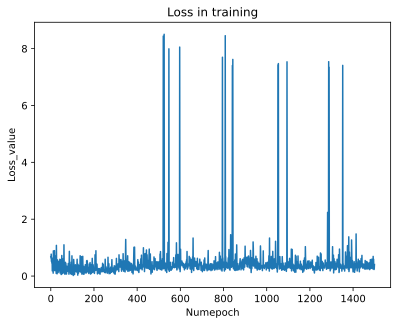

In [71]:
acc_train, acc_val, model_with_K_folds = training_with_K_folds(X_train,y_train,X_validation,y_validation)
print(acc_train, acc_val)

In [72]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    precision = tp / (tp +fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return ac, precision, recall, mcc, f1

In [76]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
y_pred_test = model(X_test) > 0.5
cm_test = confusion_matrix(y_test.detach().numpy(), y_pred_test.detach().numpy())
test_ac, test_precision, test_recall, test_mcc, test_f1 = model_evaluation_calculation(cm_test)
test_error = 1 - test_ac


In [79]:
print("test accuracy :", test_ac)
print("test_precision :", test_precision)
print("test_recall :", test_recall)
print("test_f1: ", test_f1)

test accuracy : 0.8767123287671232
test_precision : 0.875
test_recall : 0.8974358974358975
test_f1:  0.8860759493670887


In [14]:
X_train_val = torch.cat((X_train,X_validation))
y_train_val = torch.cat((y_train,y_validation))
print(X_train_val.shape, y_train_val.shape)

torch.Size([410, 1024]) torch.Size([410, 1])


In [15]:
from sklearn.model_selection import cross_val_score, KFold

def training_with_K_fold(x_train=X_train, y_train=y_train,
             lr=0.007206041689487159, l2=0.004176049826978714, batch_size=128, epochs=500, num_folds=10):
    torch.manual_seed(0)
    # losses = []
    model = ann_try()
    loss_func = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    
    kf = KFold(n_splits=num_folds, shuffle=True)
    fold_train_accuracies = []
    fold_val_accuracies = []
    fold_train_losses = []
    fold_val_losses = []

    for fold, (train_index, val_index) in enumerate(kf.split(x_train)):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        train_ds = TensorDataset(x_train_fold, y_train_fold)
        train_dl = DataLoader(train_ds, batch_size=batch_size)

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_dl:
                pred = model(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            # losses.append(loss)

        model.eval()
        # Train dataset
        y_pred_train = model(x_train_fold)
        loss_train = loss_func(y_pred_train, y_train_fold)
        y_pred_train_bin = y_pred_train > 0.5
        acc_train = 100 * torch.mean((y_pred_train_bin == y_train_fold).float())
        # Validation dataset
        y_pred_val = model(x_val_fold)
        loss_val = loss_func(y_pred_val, y_val_fold)
        y_pred_val_bin = y_pred_val > 0.5
        acc_val = 100 * torch.mean((y_pred_val_bin == y_val_fold).float())
        
        fold_train_losses.append(loss_train)
        fold_val_losses.append(loss_val)

        fold_train_accuracies.append(acc_train)
        fold_val_accuracies.append(acc_val)

    average_train_accuracy = sum(fold_train_accuracies) / num_folds
    average_val_accuracy = sum(fold_val_accuracies) / num_folds
    print("Average Accuracy on train set:", average_train_accuracy)
    print("Average Accuracy on validation set:", average_val_accuracy)

    return fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies

In [16]:
fold_train_losses, fold_val_losses,fold_train_accuracies, fold_val_accuracies = training_with_K_fold(x_train=X_train_val, y_train=y_train_val)

Average Accuracy on train set: tensor(93.4688)
Average Accuracy on validation set: tensor(85.3658)


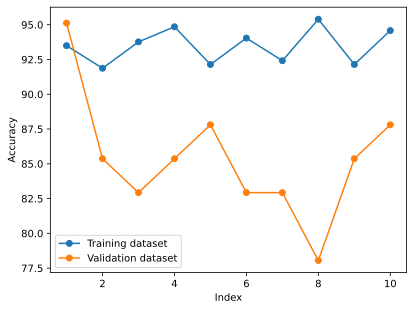

In [17]:
fold_train_accuracies_tensor = torch.tensor(fold_train_accuracies)
fold_val_accuracies_tensor = torch.tensor(fold_val_accuracies)
index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(index,fold_train_accuracies_tensor.detach().numpy(), marker='o', label='Training dataset')
plt.plot(index,fold_val_accuracies_tensor.detach().numpy(), marker='o', label='Validation dataset')

# plt.plot(fold_train_losses.detach().numpy(), index, marker='o', label='Training dataset')
# plt.plot(fold_val_losses.detach().numpy(), index, marker='o', label='Validation dataset')
plt.xlabel('Index')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

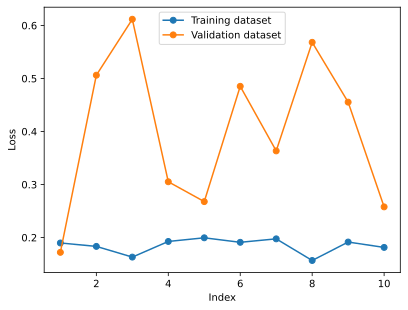

In [18]:
fold_train_losses_tensor = torch.tensor(fold_train_losses)
fold_val_losses_tensor = torch.tensor(fold_val_losses)
index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(index,fold_train_losses_tensor.detach().numpy(), marker='o', label='Training dataset')
plt.plot(index,fold_val_losses_tensor.detach().numpy(), marker='o', label='Validation dataset')

# plt.plot(fold_train_losses.detach().numpy(), index, marker='o', label='Training dataset')
# plt.plot(fold_val_losses.detach().numpy(), index, marker='o', label='Validation dataset')
plt.xlabel('Index')
plt.ylabel('Loss')
plt.legend()
plt.show()